In [2]:
def numerical_derivative_1d(func, epsilon):
    """
    Функция для приближённого вычисления производной функции одной переменной.
    :param func: float -> float — произвольная дифференцируемая функция
    :param epsilon: float — максимальная величина приращения по оси Ох
    :return: другая функция, которая приближённо вычисляет производную в точке
    """
    def deriv_func(x):
        """
        :param x: float — точка, в которой нужно вычислить производную
        :return: приближённое значение производной в этой точке
        """
        return (func(x + epsilon) - func(x))/epsilon

    return deriv_func

In [1]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def polynom_to_prime(x):
    return 20 * x**5 + x**3 - 5 * x**2 + 2 * x + 2.0


def primed_poly(x):
    return 100 * x**4 + 3 * x**2 -10 * x + 2.0


approx_deriv = numerical_derivative_1d(polynom_to_prime, 1e-5)

grid = np.linspace(-2, 2, 100)
right_flag = True
tol = 0.05
debug_print = []

for x in grid:
    estimation_error = abs(primed_poly(x) - approx_deriv(x))
    if estimation_error > tol:
        debug_print.append((estimation_error, primed_poly(x), approx_deriv(x)))
        right_flag = False

if not right_flag:
    print("Что-то не то...")
    print(debug_print)
    plt.plot(grid, primed_poly(grid), label="Истинная производная")
    plt.plot(grid, approx_deriv(grid), label="Численное приближение")
    plt.legend()

print(str(right_flag))

True


In [4]:
def grad_descent_v1(f, deriv, x0=None, lr=0.1, iters=1001, callback=None):
    """
    Реализация градиентного спуска для функций с одним локальным минимумом,
    совпадающим с глобальным. Все тесты будут иметь такую природу.
    :param func: float -> float — функция
    :param deriv: float -> float — её производная
    :param x0: float — начальная точка
    :param lr: float — learning rate
    :param iters: int — количество итераций
    :param callback: callable — функция логирования
    """

    if x0 is None:
        # Если точка не дана, сгенерируем случайную
        # из стандартного нормального распределения.
        # При таком подходе начальная точка может быть
        # любой, а не только из какого-то ограниченного диапазона
        # np.random.seed(179)
        x0 = np.random.uniform()
    x = x0
    count = 1
    while count < iters:
        count += 1
        callback(x, f(x))  # не забывайте логировать
        x -= lr * deriv(x)
    return x

In [5]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i],
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i],
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)


def test_convergence_1d(grad_descent, test_cases, tol=1e-2, axes=None, grid=None):
    """
    Функция для проверки корректности вашего решения в одномерном случае.
    Она же используется в тестах на Stepik, так что не меняйте её код!
    :param grad_descent: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция (обязательно)
        - "deriv" — её производная (обязательно)
        - "start" — начальная точка start (м.б. None) (опционально)
        - "low", "high" — диапазон для выбора начальной точки (опционально)
        - "answer" — ответ (обязательно)
    При желании вы можете придумать и свои тесты.
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :param grid: np.array(float), точки на оси Ох для отрисовки тестов
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent(*test_input.values(), callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            x_steps = np.array(callback.x_steps)
            y_steps = np.array(callback.y_steps)
            plot_convergence_1d(
                test_input["func"], x_steps, y_steps,
                ax, grid, key
            )
            ax.axvline(answer, 0, linestyle="--", c="red",
                        label=f"true answer = {answer}")
            ax.axvline(res_point, 0, linestyle="--", c="xkcd:tangerine",
                        label=f"estimate = {np.round(res_point, 3)}")
            ax.legend(fontsize=16)
        # Проверяем, что найдення точка достаточно близко к истинной
        if abs(answer - res_point) > tol or np.isnan(res_point):
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log

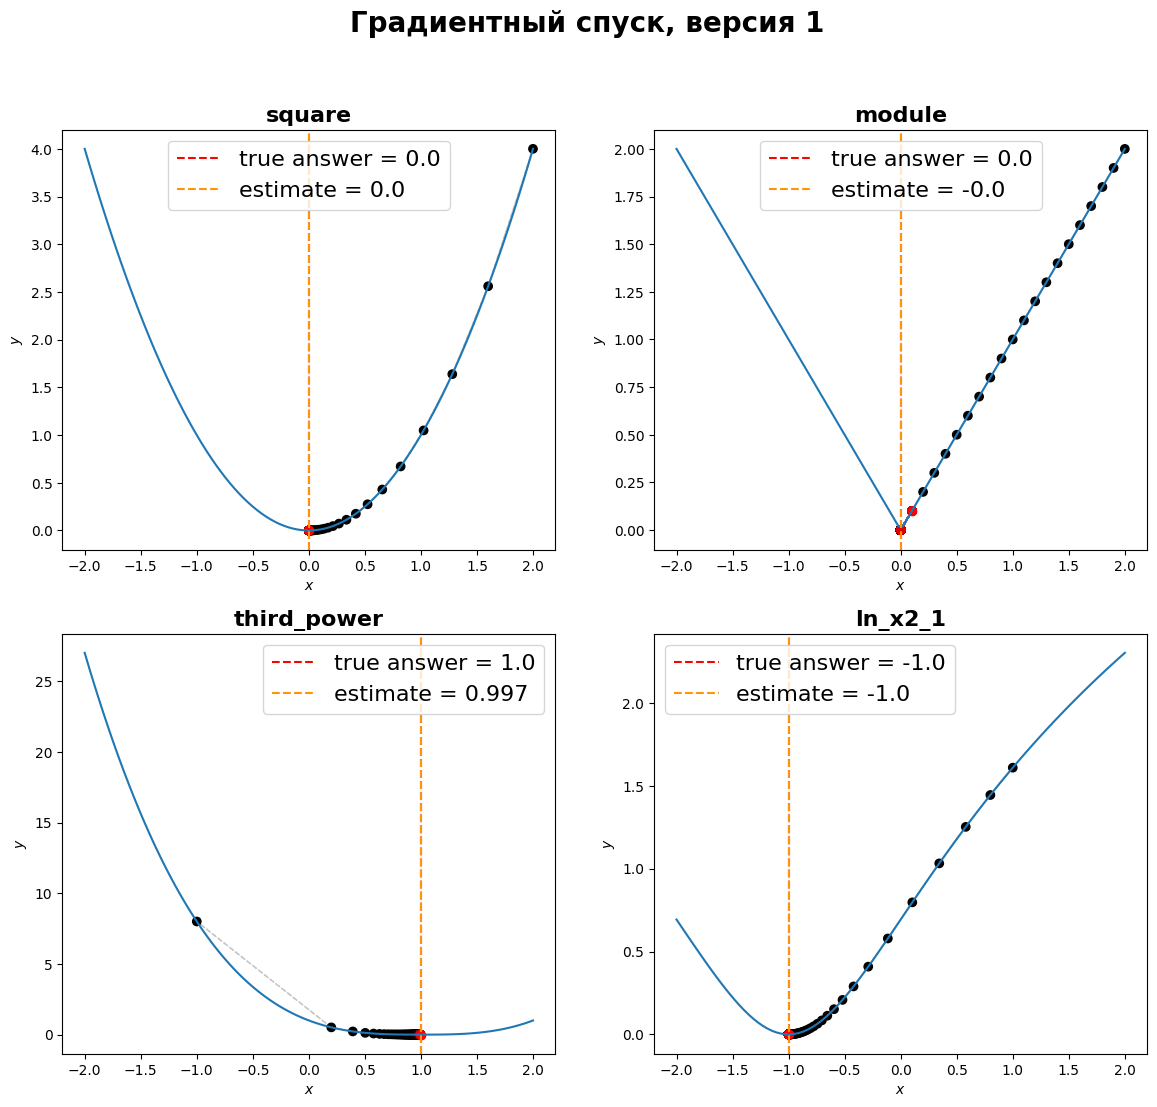

In [6]:
test_cases = {
    "square": {
        "func" : lambda x: x * x,
        "deriv" : lambda x: 2 * x,
        "start" : 2,
        "answer" : 0.0
    },
    "module": {
        "func" : lambda x: abs(x),
        "deriv" : lambda x: 1 if x > 0 else -1,
        "start" : 2,
        "answer" : 0.0
    },
    "third_power": {
        "func" : lambda x: abs((x - 1)**3),
        "deriv" : lambda x: 3 * (x - 1)**2 * np.sign(x-1),
        "start" : -1,
        "answer" : 1.0
    },
    "ln_x2_1": {
        "func" : lambda x: np.log((x + 1)**2 + 1),
        "deriv" : lambda x: 2 * (x + 1) / (x**2 +1),
        "start" : 1,
        "answer" : -1.0
    }
}



tol = 1e-2  # желаемая точность
fig, axes = plt.subplots(2,2, figsize=(14, 12))
fig.suptitle("Градиентный спуск, версия 1", fontweight="bold", fontsize=20)
grid = np.linspace(-2, 2, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v1, test_cases, tol,
    axes, grid
)
if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)

In [7]:
from math import sin, cos, tan, exp, sqrt, pi
import numpy as np

def grad_1(x, y, z):
    #возвращает кортеж из 3 чисел --- частных производных по x,y,z

    dx = z*cos(x*z) + exp(x)
    dy = -2*y*z
    dz = x*cos(x*z)-y*y
    return (dx, dy, dz)

In [8]:
#Тестируем нашу функцию
import numpy as np

assert np.allclose(grad_1(1,1,1), (3.258584134327185, -2, -0.45969769413186023), atol=5e-6)
assert np.allclose(grad_1(1, 8, 0), (2.718281828459045, 0, -63.0), atol=5e-6)
assert np.allclose(grad_1(-11,pi,1), (0.004442399688841031, -6.283185307179586, -9.918287078957917), atol=5e-6)

In [9]:
from math import sin, cos, tan, exp, sqrt, pi
def grad_2(x, y, z):
    #возвращает кортеж из 3 чисел --- частных производных по x,y,z
    dx = -1/(cos(exp(x+y)))*sin(exp(x+y))*exp(x+y)-1/x
    dy =  -1/(cos(exp(x+y)))*sin(exp(x+y))*exp(x+y)-1/y
    dz = 0
    return (dx, dy, dz)

In [10]:
#Тестируем нашу функцию

assert np.allclose(grad_2(1,1,0), (-15.73101919885423, -15.73101919885423, 0), atol=5e-6)
assert np.allclose(grad_2(-10, 3, 0), (0.09999916847105042, -0.3333341648622829, 0), atol=5e-6)
assert np.allclose(grad_2(15 ,4, 0), (54654806.79650013, 54654806.6131668,0), atol=5e-6)

In [28]:
epsilon = 10**(-10)
iters = 10000
lr = 0.5

In [26]:
def numerical_derivative_2d(func, epsilon):
    """
    Функция для приближённого вычисления градиента функции двух переменных.
    :param func: np.array[2] -> float — произвольная дифференцируемая функция
    :param epsilon: float — максимальная величина приращения по осям
    :return: другая функция, которая приближённо вычисляет градиент в точке
    """
    def grad_func(x):
        """
        :param x: np.array[2] — точка, в которой нужно вычислить градиент
        :return: np.array[2] — приближённое значение градиента в этой точке
        """
        x_x = [x[0] + epsilon, x[1]]
        x_y = [x[0], x[1] + epsilon]
        func_hatch_x = (func(x_x) - func(x)) / epsilon
        func_hatch_y = (func(x_y) - func(x)) / epsilon
        return (func_hatch_x, func_hatch_y)

    return grad_func


def grad_descent_2d(func,low=0, high=0, start=None, callback=None):
    """
    Реализация градиентного спуска для функций двух переменных

    Обратите внимание, что здесь градиент функции не дан.
    Его нужно вычислять приближённо.

    :param func: np.ndarray -> float — функция
    """

    # Инициализируем start случайными числами,
    # если стартовая точка не дана
    if start is None:
        start = np.random.randn(2)

    eps = 1e-10
    df = numerical_derivative_2d(func, eps)
    count = 0
    while count < iters:
        callback(start, func(start))
        start -= np.array(list(map(lambda x: x * lr, df(start))))
        count += 1

    return start

In [13]:
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param steps: np.array[N x 2] — шаги алгоритма
    :param ax: холст для отрисовки графика
    :param xlim: tuple(float), 2 — диапазон по первой оси
    :param ylim: tuple(float), 2 — диапазон по второй оси
    :param cmap: str — название палитры
    :param title: str — заголовок графика
    """

    ax.set_title(title, fontsize=20, fontweight="bold")
    # Отрисовка значений функции на фоне
    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid
    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)
    # Отрисовка шагов алгоритма в виде стрелочек
    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    # Отрисовка шагов алгоритма в виде точек
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1],
               color="red", label=f"estimate = {np.round(steps[-1], 2)}")
    # Финальное оформление графиков
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

In [14]:
def test_convergence_2d(grad_descent_2d, test_cases, tol, axes=None):
    """
    Функция для проверки корректности вашего решения в двумерном случае.
    Она же используется в тестах на Stepik, так что не меняйте её код!
    :param grad_descent_2d: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция
        - "deriv" — её производная
        - "low", "high" — диапазон для выбора начальной точки
        - "answer" — ответ
    При желании вы можете придумать и свои тесты.
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent_2d(**test_input, callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            plot_convergence_2d(
                np.vectorize(test_input["func"], signature="(n)->()"),
                np.vstack(callback.x_steps),
                ax=ax,
                xlim=(test_input["low"], test_input["high"]),
                ylim=(test_input["low"], test_input["high"]),
                title=key
            )
        # Проверяем, что найденная точка достаточно близко к истинной
        if np.linalg.norm(answer - res_point, ord=1) > tol:
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log


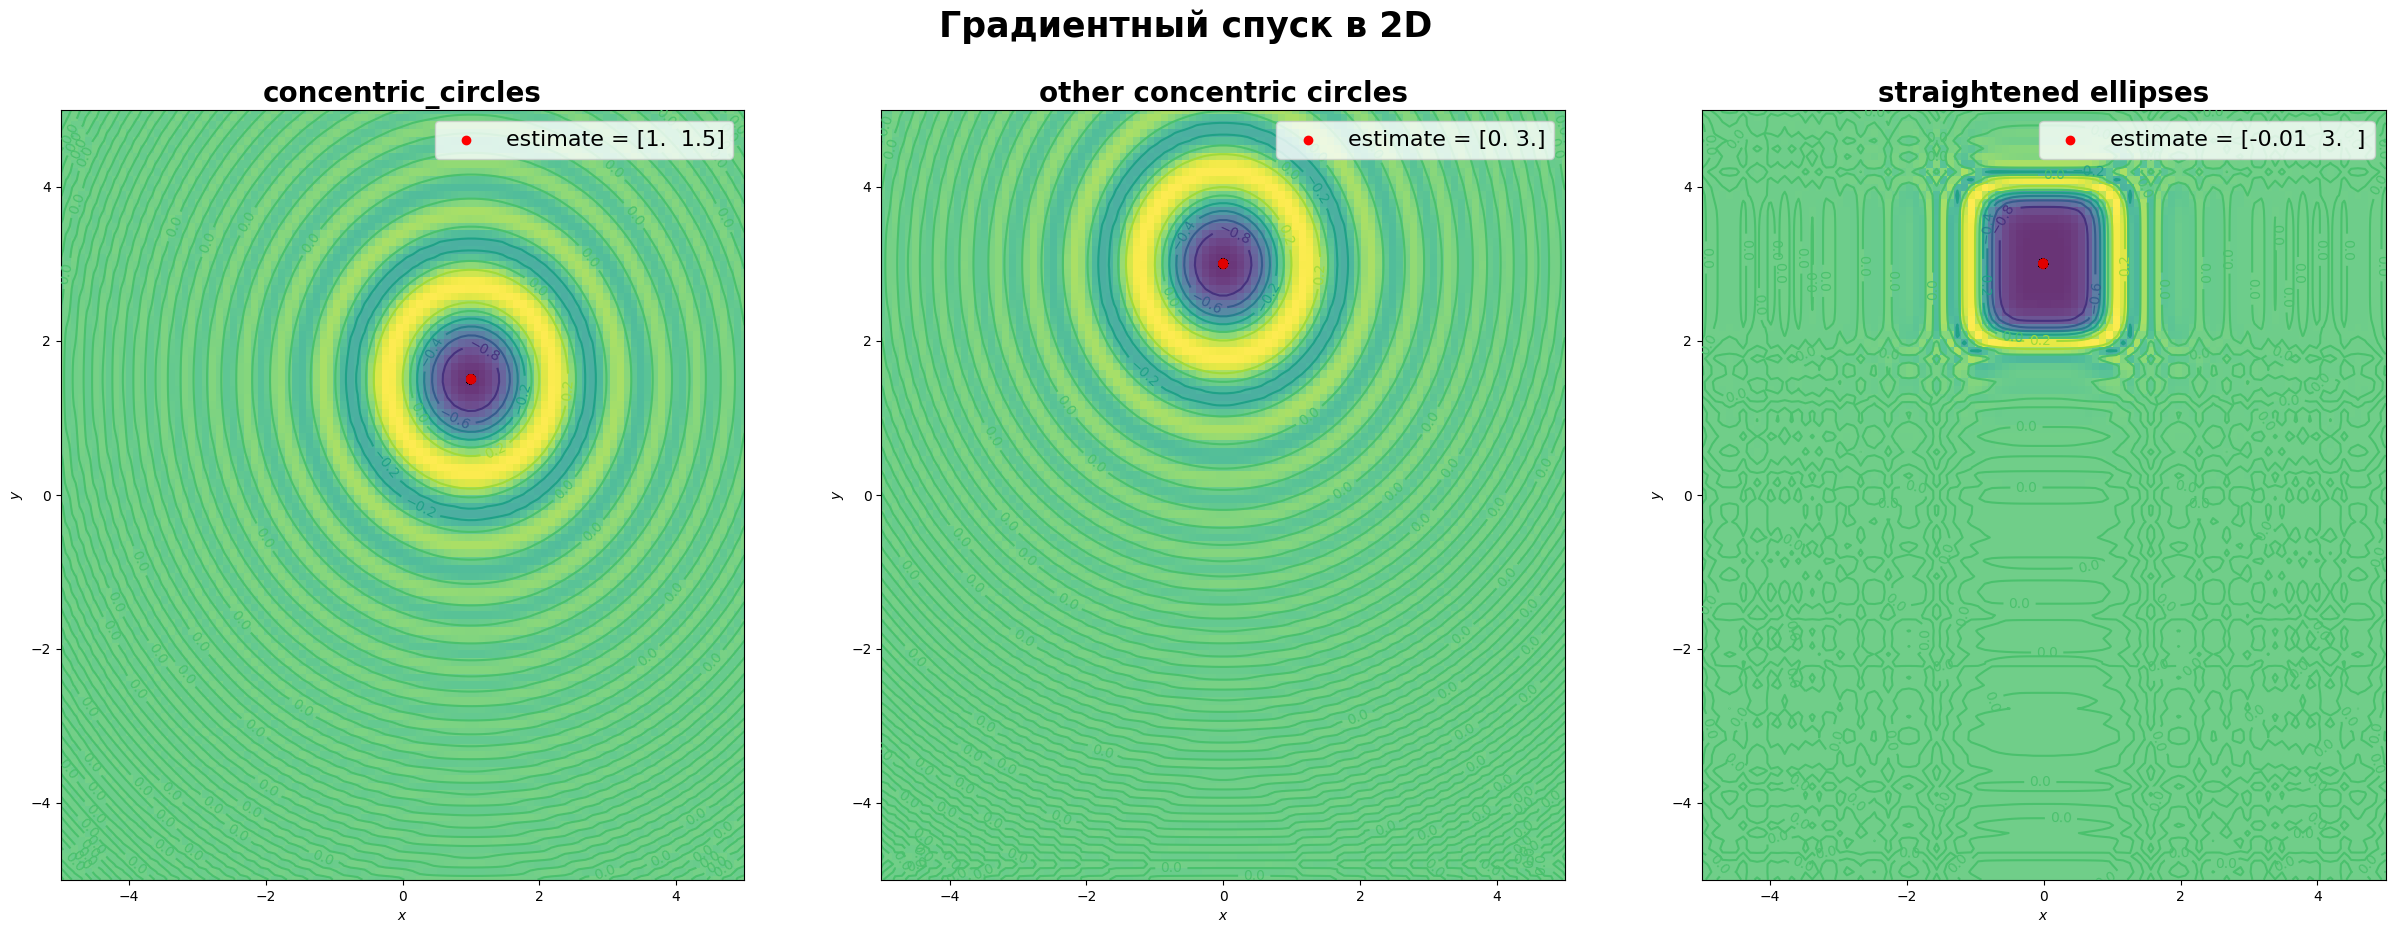

In [27]:
test_cases = {
    "concentric_circles" : {
        "func" : lambda x: (
            -1 / ((x[0] - 1)**2 + (x[1] - 1.5)**2 + 1)
            * np.cos(2 * (x[0] - 1)**2 + 2 * (x[1] - 1.5)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.2 , .7]),
        "answer" : np.array([1, 1.5])
    },
        "other concentric circles" : {
       "func" : lambda x: (
            -1 / ((x[0])**2 + (x[1] - 3)**2 + 1)
            * np.cos(2 * (x[0])**2 + 2 * (x[1] - 3)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([1.1, 3.3]),
        "answer" : np.array([0, 3])
    },
    "straightened ellipses" : {
        "func" : lambda x: (
            -1 / ((x[0] )**4 + (x[1] - 3)**6 + 1)
            * np.cos(2 * (x[0])**4 + 2 * (x[1] - 3)**6)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.8, 3.001]), # точка так близко к ответу тк в окрестности ответа градиент маленкьий и функция очень плохо сходится
        "answer" : np.array([0, 3])
    },
}
tol = 1e-2  # желаемая точность

fig, axes = plt.subplots(1, 3, figsize=(30, 10), squeeze=False)
fig.suptitle("Градиентный спуск в 2D", fontsize=25, fontweight="bold")
is_correct, debug_log = test_convergence_2d(grad_descent_2d, test_cases, tol, axes)

if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)

In [ ]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt

In [23]:
v = np.array([1, 2])
v -= np.array(list(map(lambda x: x * 2, (2,3))))